# Integration of CITE-seq and scRNA-seq data with totalVI

Here we demonstrate how to integrate CITE-seq and scRNA-seq datasets with totalVI. The same principles here can be used to integrate CITE-seq datasets with different sets of measured proteins.

If running in Colab, navigate to Runtime -> Change runtime type and ensure you're using a Python 3 runtime with GPU hardware accelerator installation in Colab can take several minutes.



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yoseflab/scvi/blob/dataset_refactor/docs/tutorials/cite_scrna_integration_w_totalVI.ipynb)

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install --quiet git+https://github.com/yoseflab/scvi@dataset_refactor#egg=scvi[notebooks]

In [2]:
import scvi
print(scvi.__version__)

0.6.6


## Imports and data loading

In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import anndata
import os
import seaborn as sns
from plotnine import *

from scvi.dataset import setup_anndata, highly_variable_genes_seurat_v3, pbmcs_10x_cite_seq
from scvi.models import TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer
from scvi import set_seed

if IN_COLAB:
    %matplotlib inline

# Sets the random seed for torch and numpy
set_seed(0)

sc.set_figure_params(figsize=(4, 4))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Here we focus on two CITE-seq datasets of peripheral blood mononuclear cells from 10x Genomics and used in the totalVI manuscript. We have already filtered these datasets for doublets and low-quality cells and genes.

The quality of totalVI's protein imputation is somewhat reliant on how well the datasets mix in the latent space. In other words, it's assumed here the datasets largely share the same cell subpopulations.

In [4]:
adata = pbmcs_10x_cite_seq(run_setup_anndata=False)

For example, 
```python
import scanpy as sc
adata = sc.read_10x_mtx(save_path_10x, gex_only=False)
pro_exp = adata[
    :, adata.var["feature_types"] == "Antibody Capture"
].X.A
protein_names = np.array(
    adata.var_names[adata.var["feature_types"] == "Antibody Capture"]
)
adata = adata[
    :, adata.var["feature_types"] != "Antibody Capture"
].copy()
adata.obsm["protein_expression"] = pd.DataFrame(pro_exp, index=adata.obs_names, columns = protein_names)
adata.X = adata.X.A
adata.var_names_make_unique()
```
In this example we chose to make the counts dense (the `.A` code), this will be hardware specific. In general, totalVI will be faster if everything is loaded as dense, because each minibatch of data loaded to the model is made dense anyway.

In [5]:
# batch 0 corresponds to dataset_10k, batch 1 corresponds to dataset_5k
batch = adata.obs.batch.values.ravel()
adata.obs.batch

index
AAACCCAAGATTGTGA-1-0    0
AAACCCACATCGGTTA-1-0    0
AAACCCAGTACCGCGT-1-0    0
AAACCCAGTATCGAAA-1-0    0
AAACCCAGTCGTCATA-1-0    0
                       ..
TTTGGTTGTACGAGTG-1-1    1
TTTGTTGAGTTAACAG-1-1    1
TTTGTTGCAGCACAAG-1-1    1
TTTGTTGCAGTCTTCC-1-1    1
TTTGTTGCATTGCCGG-1-1    1
Name: batch, Length: 10849, dtype: category
Categories (2, object): [0, 1]

Now we hold-out the proteins of the 5k dataset. To do so, we can replace all the values with 0s. TotalVI recognizes that proteins of all 0 in a particular batch are "missing". We will store the original values to validate after training.

In [6]:
held_out_proteins = adata.obsm["protein_expression"][batch == "1"].copy()
adata.obsm["protein_expression"][batch == "1"] = np.zeros_like(adata.obsm["protein_expression"][batch == "1"])

In [7]:
highly_variable_genes_seurat_v3(adata, batch_key="batch", n_top_genes=4000)
adata = adata[:, adata.var.highly_variable].copy()

[2020-07-21 22:19:20,523] INFO - scvi.dataset._preprocessing | added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [8]:
setup_anndata(adata, batch_key="batch", protein_expression_obsm_key="protein_expression")

[2020-07-21 22:19:22,435] INFO - scvi.dataset._anndata | Using data from adata.X
[2020-07-21 22:19:22,437] INFO - scvi.dataset._anndata | Using batches from adata.obs["batch"]
[2020-07-21 22:19:22,440] INFO - scvi.dataset._anndata | No label_key inputted, assuming all cells have same label
[2020-07-21 22:19:22,444] INFO - scvi.dataset._anndata | Computing library size prior per batch
[2020-07-21 22:19:22,529] INFO - scvi.dataset._anndata | Using protein expression from adata.obsm['protein_expression']
[2020-07-21 22:19:22,530] INFO - scvi.dataset._anndata | Using protein names from columns of adata.obsm['protein_expression']
[2020-07-21 22:19:22,532] INFO - scvi.dataset._anndata | Found batches with missing protein expression
[2020-07-21 22:19:22,533] INFO - scvi.dataset._anndata | Successfully registered anndata object containing 10849 cells, 4000 genes, and 2 batches 
Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels', 'protein_expression']


In [9]:
sum_stats = adata.uns["scvi_summary_stats"]
print(sum_stats)

{'n_batch': 2, 'n_cells': 10849, 'n_genes': 4000, 'n_labels': 1, 'n_proteins': 14, 'protein_names': ['CD3_TotalSeqB', 'CD4_TotalSeqB', 'CD8a_TotalSeqB', 'CD14_TotalSeqB', 'CD15_TotalSeqB', 'CD16_TotalSeqB', 'CD56_TotalSeqB', 'CD19_TotalSeqB', 'CD25_TotalSeqB', 'CD45RA_TotalSeqB', 'CD45RO_TotalSeqB', 'PD-1_TotalSeqB', 'TIGIT_TotalSeqB', 'CD127_TotalSeqB']}


## Prepare and run model

In [10]:
totalvae = TOTALVI(
    sum_stats["n_genes"], 
    sum_stats["n_proteins"], 
    n_batch=sum_stats["n_batch"],
    protein_batch_mask=adata.uns["totalvi_batch_mask"]
)
use_cuda = True
lr = 4e-3
n_epochs = 500
    
trainer = TotalTrainer(
    totalvae,
    adata,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    batch_size=256,
    use_adversarial_loss=True
)

In [11]:
trainer.train(lr=lr, n_epochs=n_epochs)

[2020-07-21 22:19:30,199] INFO - scvi.inference.inference | KL warmup for 8136.75 iterations
training:  91%|█████████▏| 457/500 [16:30<01:25,  1.99s/it][2020-07-21 22:36:03,080] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 45 epochs
[2020-07-21 22:36:03,081] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.


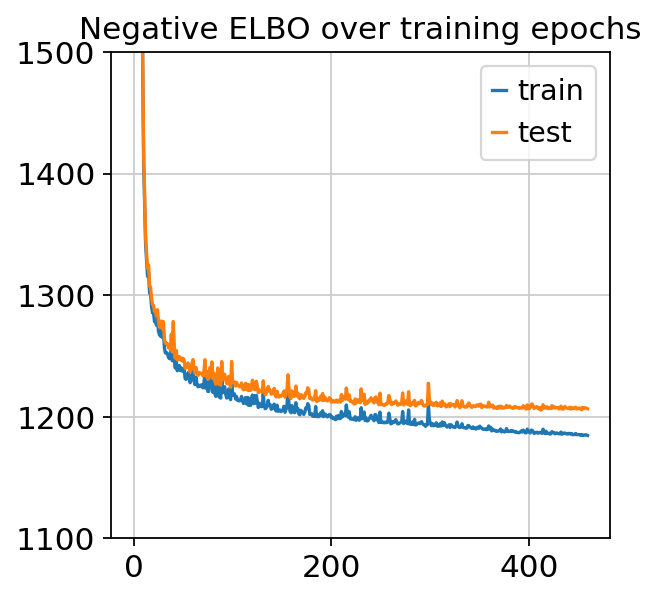

In [12]:
plt.plot(trainer.history["elbo_train_set"], label="train")
plt.plot(trainer.history["elbo_test_set"], label="test")
plt.title("Negative ELBO over training epochs")
plt.ylim(1100, 1500)
plt.legend()

## Analyze outputs

We use scanpy to do clustering, umap, visualization after running totalVI.

In [13]:
# create posterior on full data
full_posterior = trainer.create_posterior(type_class=TotalPosterior)
# update the batch size for GPU operations on Colab
full_posterior = full_posterior.update_batch_size(32)

# extract latent space
latent_mean = full_posterior.get_latent()[0]

# Number of Monte Carlo samples to average over
n_samples = 25
# Probability of background for each (cell, protein)
py_mixing = full_posterior.sequential().get_sample_mixing(n_samples=n_samples, give_mean=True)
parsed_protein_names = [p.split("_")[0] for p in adata.obsm["protein_expression"].columns]
protein_foreground_prob = pd.DataFrame(
    data=(1 - py_mixing), columns=parsed_protein_names
)
# We condition here on batch 0, where all the proteins were observed
# The denoised expression accounts for measurement uncertainty and removes protein background
denoised_genes, denoised_proteins = full_posterior.sequential().get_normalized_denoised_expression(
    n_samples=n_samples, give_mean=True, transform_batch=0
)

# To compare to the held-out data we also include the background component of expression
# This would be the mean of the negative binomial mixture
protein_means = full_posterior.get_protein_mean(n_samples=n_samples, transform_batch=0)

<div class="alert alert-info">

Note

In most instances, we'd use the `denoised_proteins` for downstream analysis, but to compare to the observed data, we use the `protein_means`, which includes the foreground and background components.

</div>

In [14]:
post_adata = anndata.AnnData(X=adata.X)
post_adata.obsm["X_totalVI"] = latent_mean
d_names = ["PBMC 10k", "PBMC 5k"]
post_adata.obs["batch"] = pd.Categorical(d_names[b] for b in adata.obs.batch.astype(int).ravel())
sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=30, metric="correlation")
sc.tl.umap(post_adata, min_dist=0.5)
sc.tl.leiden(post_adata, key_added="leiden_totalVI", resolution=0.8)

Trying to set attribute `.uns` of view, copying.


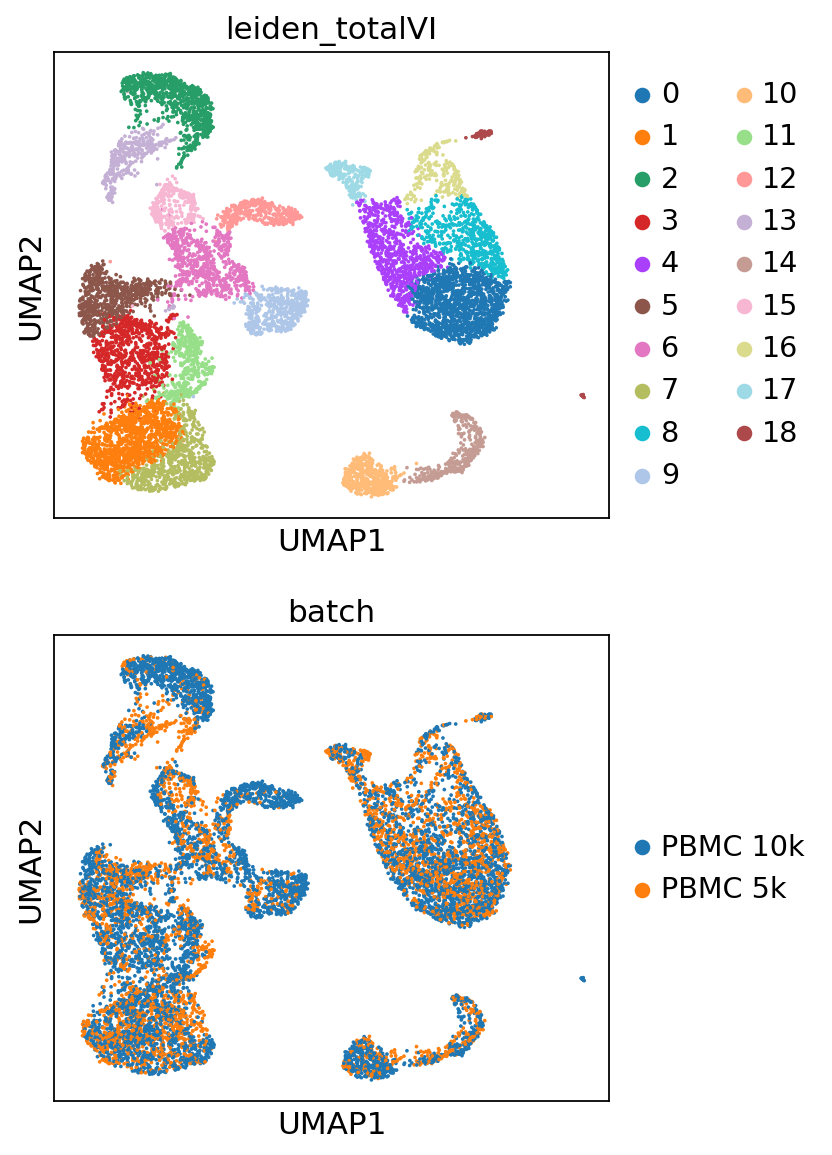

In [15]:
perm_inds = np.random.permutation(len(post_adata))
sc.pl.umap(
    post_adata[perm_inds], 
    color=["leiden_totalVI", "batch"],
    ncols=1
)

In [16]:
batch = adata.obs.batch.astype(int).values.ravel()
combined_protein = np.concatenate([adata.obsm["protein_expression"].values[batch==0], held_out_proteins], axis=0)

for i, p in enumerate(parsed_protein_names):
    post_adata.obs["{}_fore_prob".format(p)] = protein_foreground_prob[p].values
    post_adata.obs["{} imputed".format(p)] = protein_means[:, i]
    post_adata.obs["{} observed".format(p)] = combined_protein[:, i]

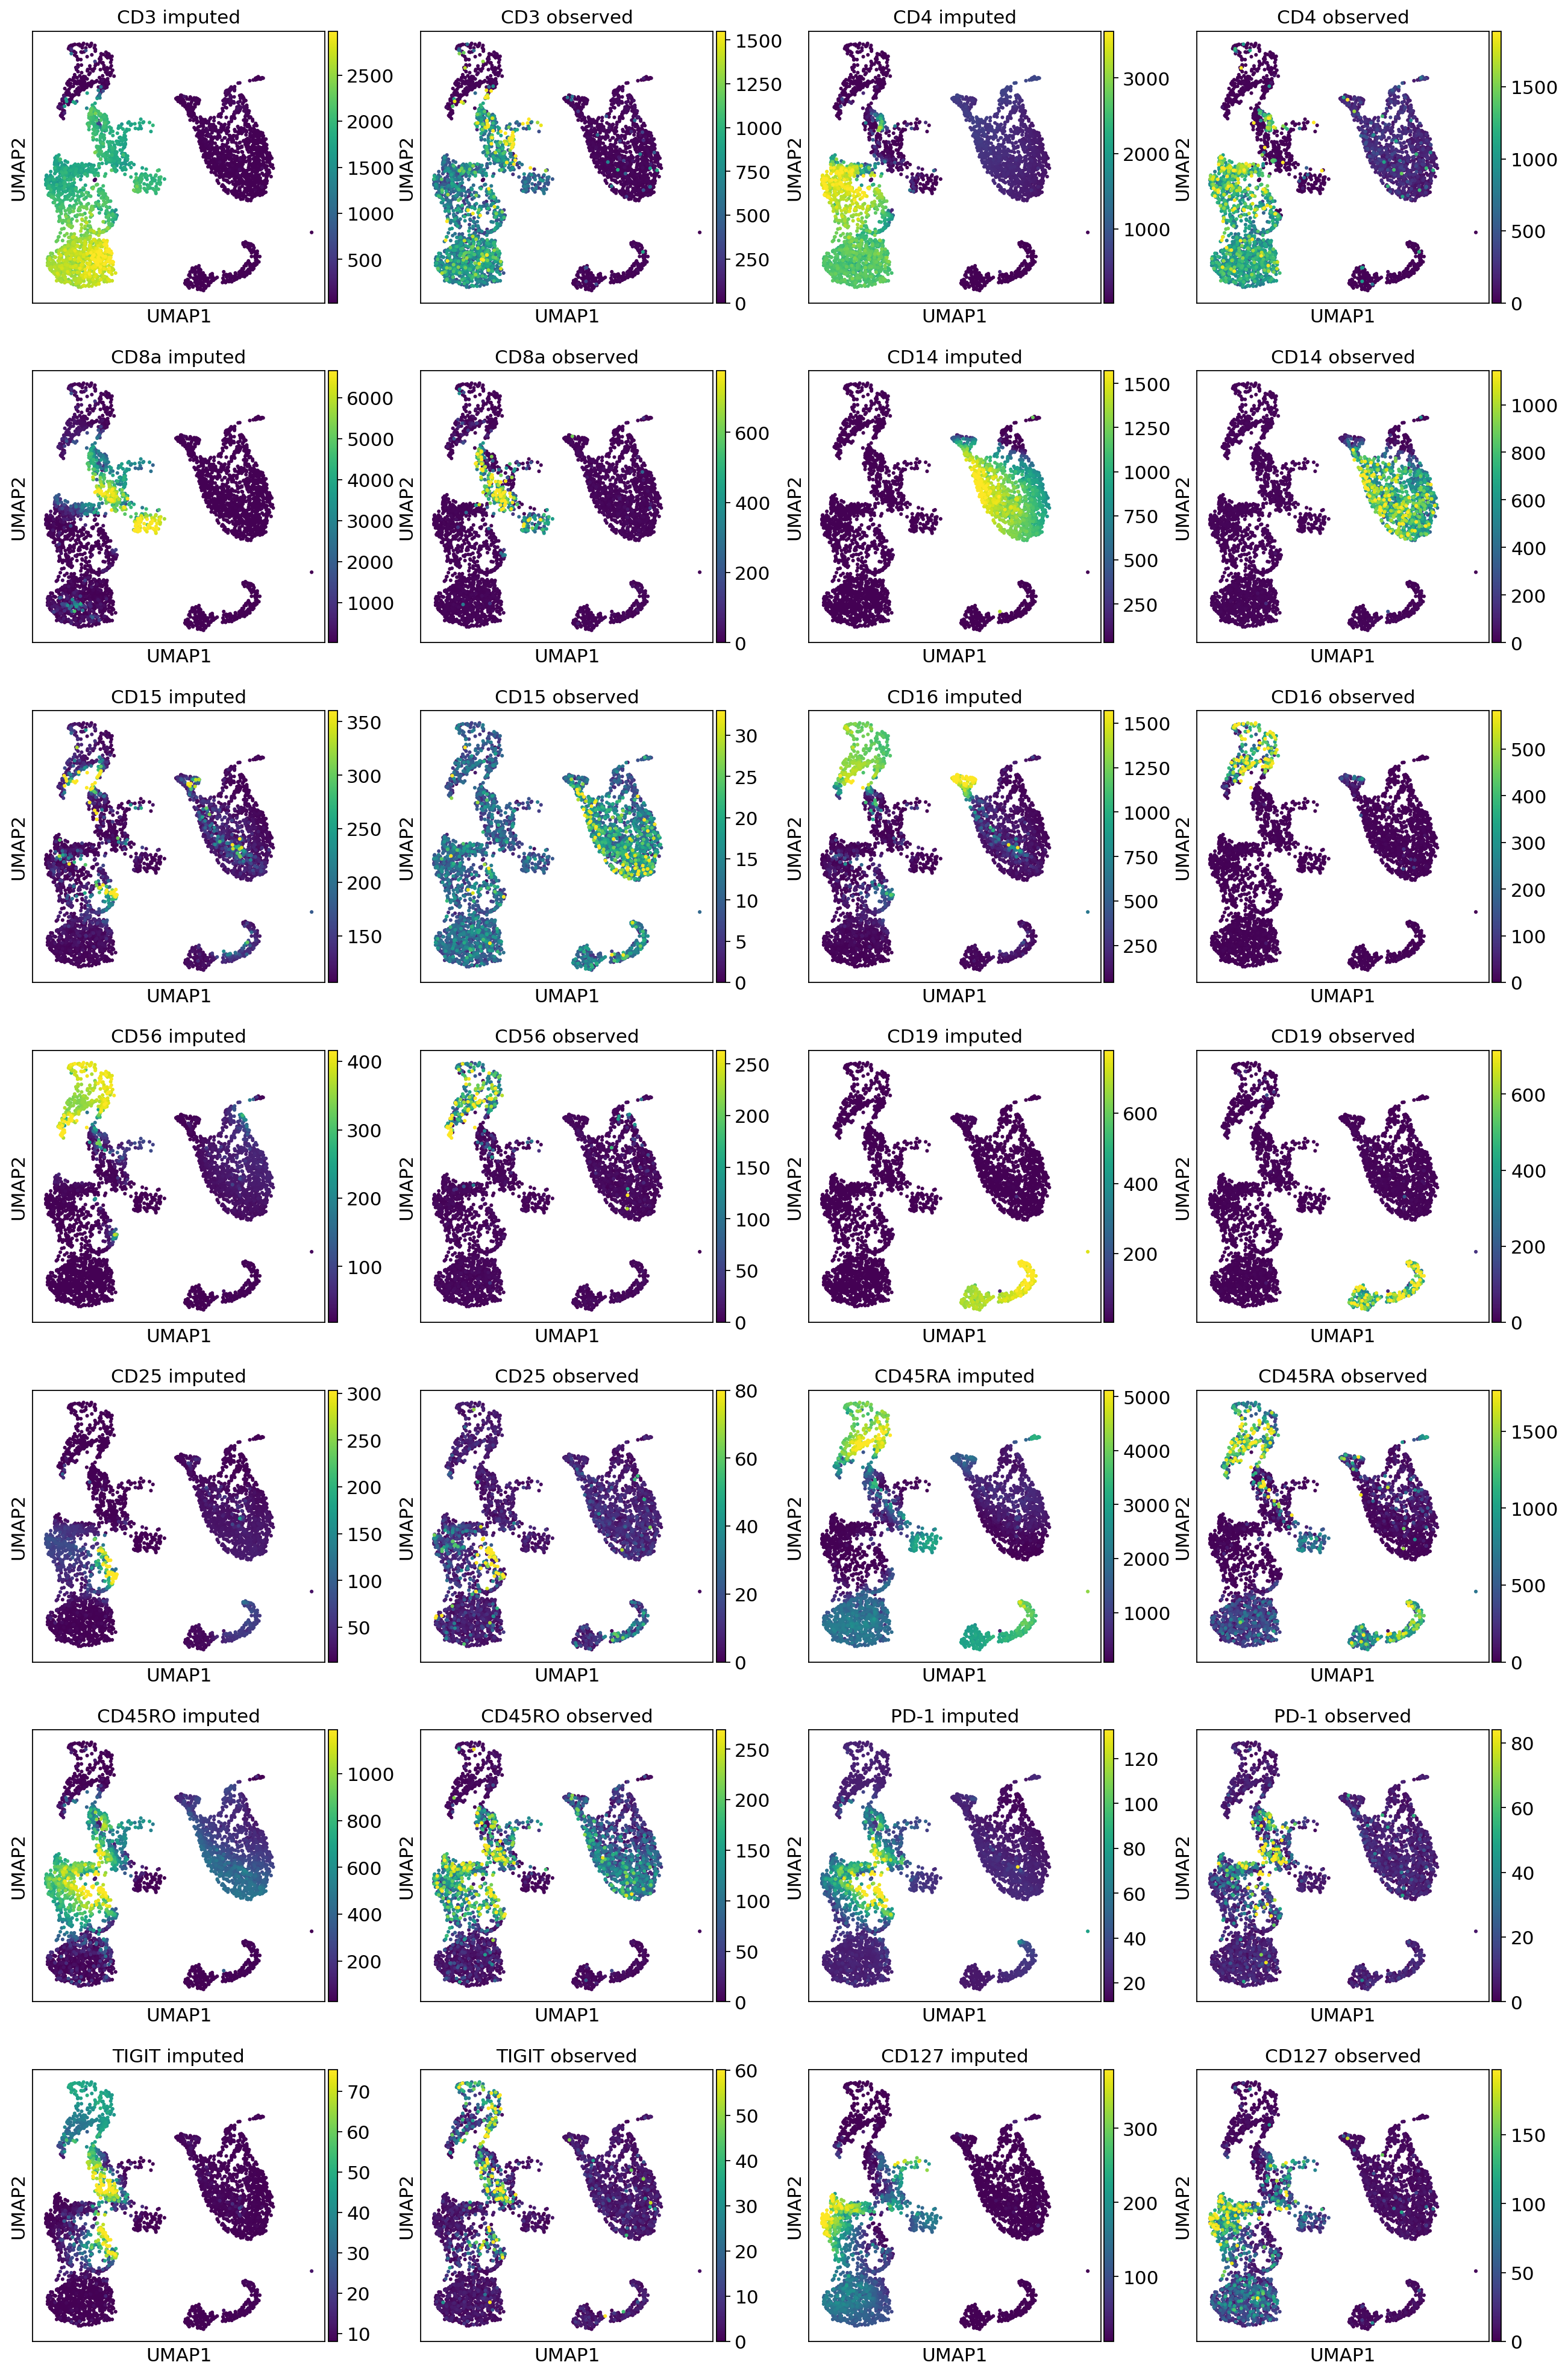

In [17]:
viz_keys = []
for p in parsed_protein_names:
    viz_keys.append(p + " imputed")
    viz_keys.append(p + " observed")

sc.pl.umap(
    post_adata[adata.obs.batch.astype(int).values.ravel() == 1],
    color=viz_keys,
    ncols=4,
    vmax="p99"
)

## Imputed vs denoised correlations

In [18]:
from scipy.stats import pearsonr
imputed_pros = protein_means[batch == 1]
held_vs_denoised = pd.DataFrame()
held_vs_denoised["Observed (log)"] = np.log1p(held_out_proteins.values.ravel())
held_vs_denoised["Imputed (log)"] = np.log1p(imputed_pros.ravel())
protein_names_corrs = []
for i, p in enumerate(parsed_protein_names):
    protein_names_corrs.append(parsed_protein_names[i] + ": Corr=" + str(np.round(pearsonr(held_out_proteins.values[:, i], imputed_pros[:, i])[0], 3)))
held_vs_denoised["Protein"] = protein_names_corrs * len(held_out_proteins)
held_vs_denoised.head()

Observed (log)  Imputed (log)           Protein
0        3.258097       3.484531   CD3: Corr=0.775
1        5.105945       5.897942   CD4: Corr=0.852
2        2.833213       3.484412  CD8a: Corr=0.752
3        6.546785       7.087820  CD14: Corr=0.905
4        2.995732       4.721883  CD15: Corr=0.023

We notice that CD15 has a really low correlation in this data. Recall that imputation involves a counterfactual query -- "what would the protein expression have been for these cells if they came from the PBMC10k dataset?" Thus, any technical issues with proteins in CD15 in PBMC10k will be reflected in the imputed values. It's the case here that CD15 was not captured as well in the PBMC10k dataset compared to the PBMC5k dataset.

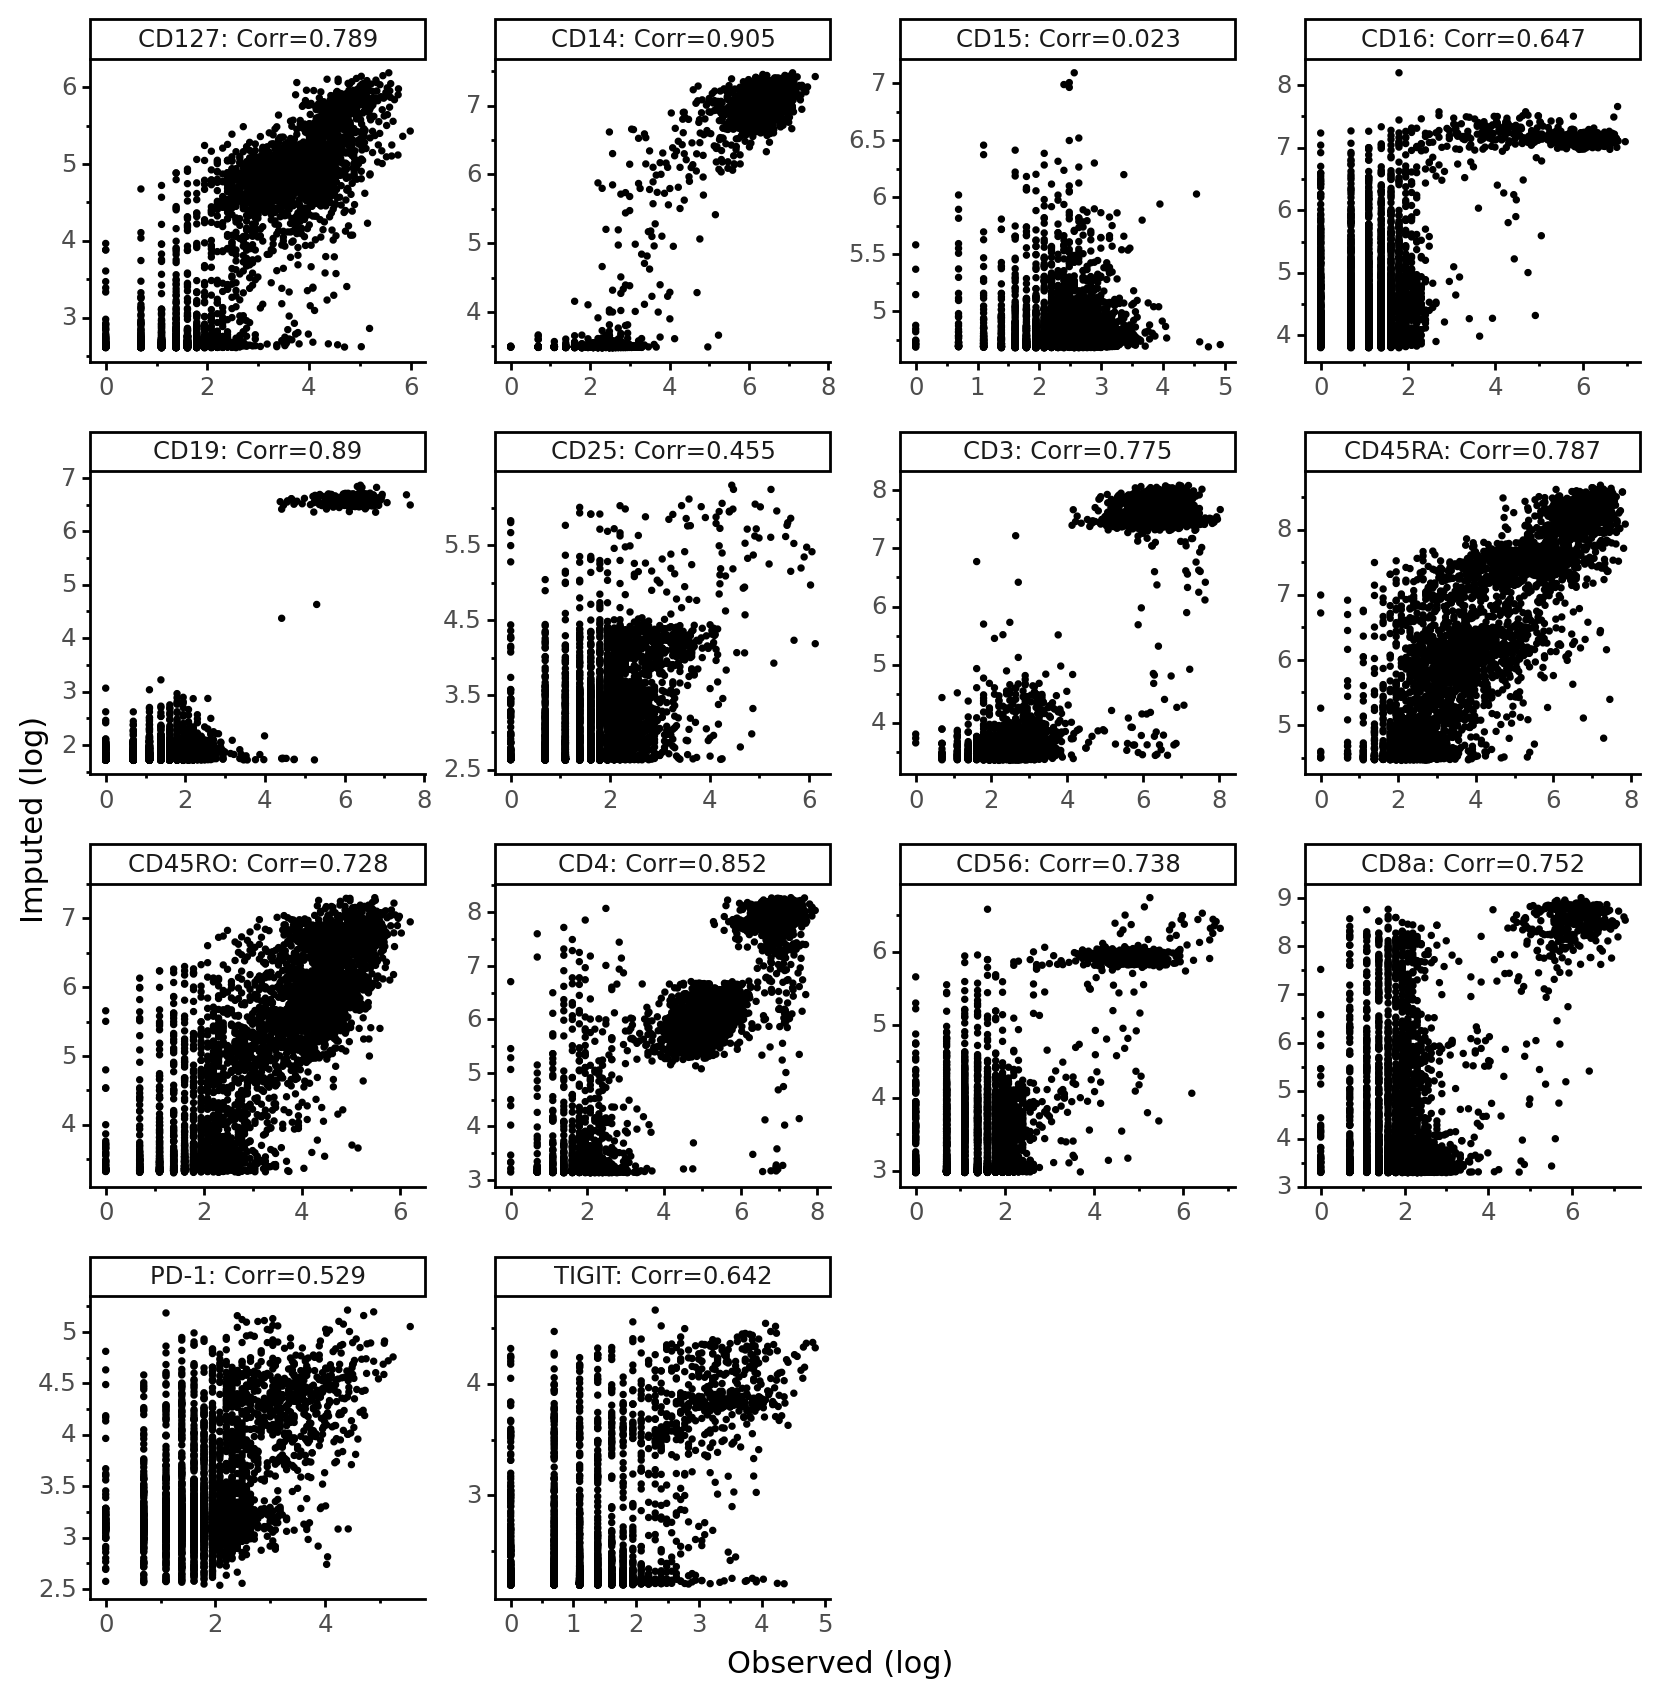

<ggplot: (8776053966193)>

In [19]:
theme_set(theme_classic)
(ggplot(held_vs_denoised, aes("Observed (log)", "Imputed (log)"))
 + geom_point(size=0.5)
 + facet_wrap("~Protein", scales="free")
 + theme(figure_size=(10, 10), panel_spacing=.35,)
)
